# ARIMA MODEL 


##### Step 1. Import modules and load dataset

In [12]:
#Import required Libraries
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from pandas import read_csv
import multiprocessing as mp

### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

In [13]:
df = pd.read_csv('NKG Historical Data.csv',delimiter=",", thousands=',')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,24400.0,24500.0,24700.0,24300.0,4.89M,0.21%
1,05/30/2024,24350.0,24400.0,24650.0,24150.0,6.99M,-1.62%
2,05/29/2024,24750.0,25250.0,25600.0,24750.0,8.00M,-1.20%
3,05/28/2024,25050.0,25250.0,25250.0,24850.0,4.43M,0.60%
4,05/27/2024,24900.0,24600.0,24900.0,24600.0,4.31M,0.40%
...,...,...,...,...,...,...,...
1308,03/07/2019,4934.5,5217.0,5217.0,4934.5,1.29M,-3.59%
1309,03/06/2019,5118.5,5223.6,5256.5,5118.5,697.98K,-2.01%
1310,03/05/2019,5223.6,5328.7,5387.9,5223.6,2.48M,0.00%
1311,03/04/2019,5223.6,5256.5,5289.3,5125.1,1.92M,3.25%


In [14]:
# Determine the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1313 non-null   object 
 1   Price     1313 non-null   float64
 2   Open      1313 non-null   float64
 3   High      1313 non-null   float64
 4   Low       1313 non-null   float64
 5   Vol.      1313 non-null   object 
 6   Change %  1313 non-null   object 
dtypes: float64(4), object(3)
memory usage: 71.9+ KB


In [15]:
# Convert data
df['Date'] = pd.to_datetime(df['Date'])

##### Step 2. Selecting attribute 

In [16]:
df = df[['Price']]
df = df.dropna() 
df = df.reset_index(drop=True) 
df

,Price
0,24400.0
1,24350.0
2,24750.0
3,25050.0
4,24900.0
...,...
1308,4934.5
1309,5118.5
1310,5223.6
1311,5223.6


##### Step 3. Split the dataset into train, test, validate

In [17]:
# Calculate the number of samples for each set
train_size = int(0.90 * len(df))
test_size = int(0.10 * len(df))

# Split data into sets
train_data = df[:train_size]
test_data = df[train_size:]

# Check the size of each set
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))

Train data size: 1181
Test data size: 132


##### Step 4. Process of training the model

In [18]:
#ADF test
r = adfuller(train_data, autolag='AIC', regression='ct')
print('ADF Statistic: {}'.format(r[0]))
print('p-value: {}'.format(r[1]))
print('Critical Values:')
for key, value in r[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.7685098766581913
p-value: 0.7197407474890314
Critical Values:
	1%: -3.9665619318127106
	5%: -3.4142652700898077
	10%: -3.1292723052259577


In [19]:
print('ADF Statistic for 1st Order Differencing')
result = adfuller(train_data.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic for 1st Order Differencing
ADF Statistic: -7.515554
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


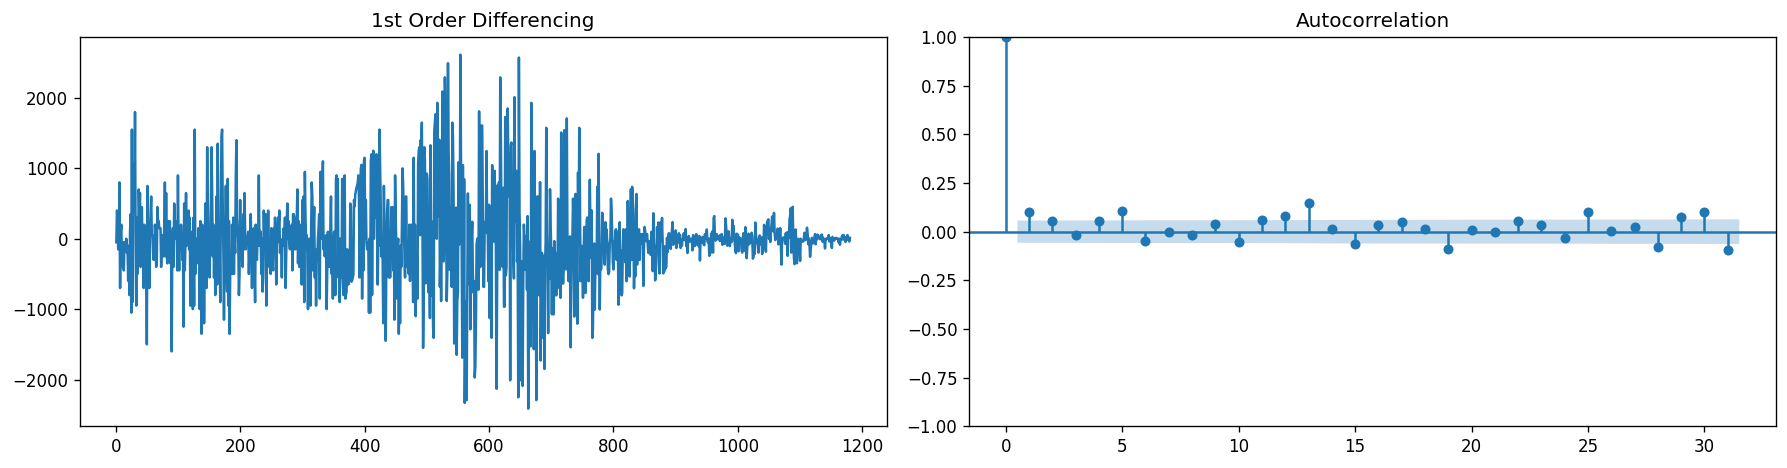

In [20]:
plt.rcParams.update({'figure.figsize': (15, 4), 'figure.dpi': 120})

# 1st Differencing
fig, ax = plt.subplots(1, 2)  # Create a figure with 1 row and 2 columns
ax[0].plot(train_data.diff()); ax[0].set_title('1st Order Differencing')
plot_acf(train_data.diff().dropna(), ax=ax[1])  # Use ax[1] for ACF plot

plt.tight_layout() 
plt.show()

In [21]:
!pip install pmdarima

In [22]:
# Process of Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train model
from pmdarima.arima import auto_arima
model = auto_arima(y_train, d=1, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=18508.554, Time=2.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18527.358, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18518.277, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18519.330, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18526.296, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18519.919, Time=0.97 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=18518.812, Time=1.35 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=18510.716, Time=4.74 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=18509.681, Time=2.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18517.948, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=18519.644, Time=1.46 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=18520.557, Time=1.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=18508.127, Time=6.69 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=18487.875, Time=2.67 sec
 ARIMA(4,1,2)(0,0,0

ARIMA(order=(4, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [23]:
# Process of Testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

##### Step 5. Evaluate the accuracy of test sets

In [24]:
# RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('RMSE:', test_rmse)

RMSE: 622.5459750736649


In [25]:
# MAPE
mape_test = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('MAPE:', mape_test)

MAPE: 11.474857478922436


In [26]:
# MAE
mae_test = np.mean(np.abs(y_test - y_pred))
print("MAE:", mae_test)

MAE: 516.7154216501478


##### Step 6. Forecasting 

In [27]:
# Process of creating an index to predict the next 90 days
last_index = df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)

# Creating an array for the next 90 days
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

# Predicting the next 90 days
y_next_90_days = model.predict(n_periods=len(x_next_90_days))

# Printing out the predicted closing prices for the next 90 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
[3785.33083623 3795.46229223 3788.20150476 3779.03991714 3784.63702148
 3794.81404233 3791.00319354 3780.34441877 3782.32526087 3793.1763677
 3793.03639048 3782.30575998 3780.6498471  3790.9616133  3794.31967956
 3784.70585535 3779.7848665  3788.44867975 3794.75306889 3787.25798837
 3779.78391523 3785.9301689  3794.33292812 3789.6729183  3780.60225629
 3783.68402552 3793.14987759 3791.69153209 3782.10714732 3781.94373941
 3791.37394074 3793.11185739 3784.09704682 3780.87491305 3789.23167913
 3793.80836338 3786.32740415 3780.5605283  3786.97828048 3793.74183241
 3788.53985237 3780.99608637 3784.86793972 3792.95920356 3790.49140911
 3782.09464433 3783.12588667 3791.58392599 3791.98046572 3783.7006793
 3781.92505896 3789.79837812 3792.86686619 3785.61079367 3781.3697506
 3787.82070262 3793.08416909 3787.5986236  3781.48767694 3785.87890094
 3792.64314637 3789.44098655 3782.23089387 3784.18518552 3791.62658815
 3790.94232102 3783.48501042 3782

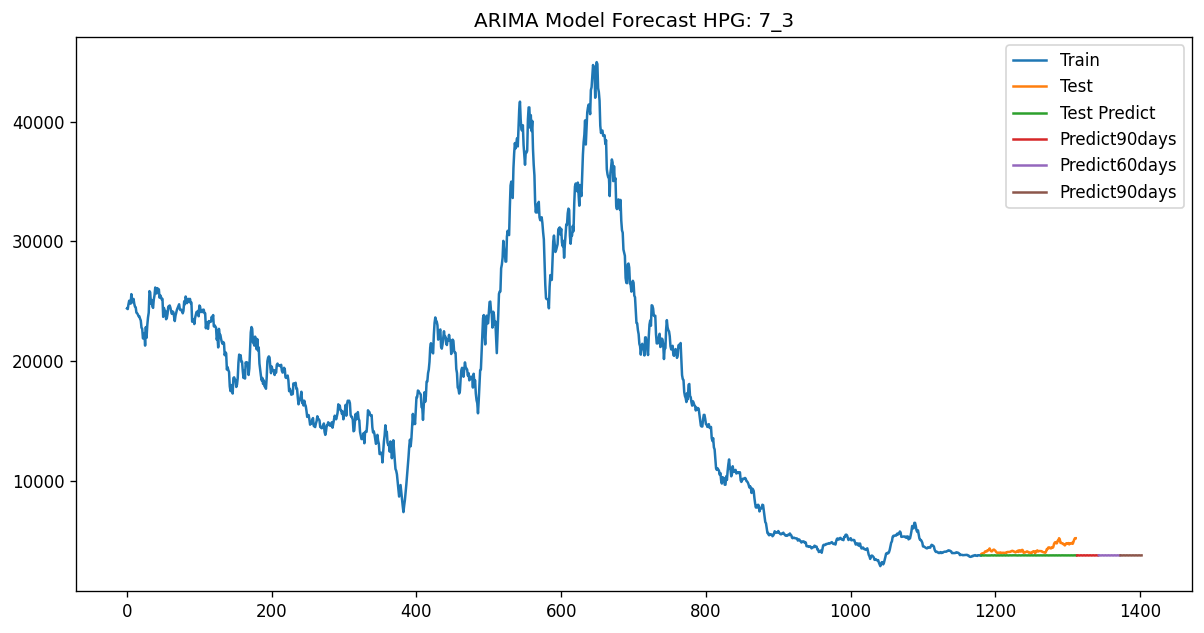

In [28]:
# Tạo DataFrame cho dự đoán test
test_predict_df = pd.DataFrame(y_pred, columns=['Price'])
test_predict_index = range(len(train_data), len(train_data)+ len(y_pred)) 
test_predict_df.index = test_predict_index

# Tạo DataFrame cho dữ liệu huấn luyện và kiểm tra
train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]

next_90_days_index = np.arange(len(df), len(df) + 90)
next_90_days_df = pd.DataFrame(y_next_90_days, index=next_90_days_index, columns=['Price'])

# Vẽ đồ thị
plt.figure(figsize=(12, 6))

# Vẽ dữ liệu huấn luyện
plt.plot(train_data_df, label='Train')

# Vẽ dữ liệu kiểm tra
plt.plot(test_data_df, label='Actual Test')

# Vẽ dự báo test predict
plt.plot(test_predict_df.index, test_predict_df['Price'], label='Test Predict')

# Vẽ dự báo 30 ngày đầu 

plt.plot(next_90_days_df.index[:30], next_90_days_df['Price'][:30], label='Next 30 days')
plt.plot(next_90_days_df.index[30:60], next_90_days_df['Price'][30:60], label='Next 60 days')
plt.plot(next_90_days_df.index[60:], next_90_days_df['Price'][60:], label='Next 90 days')

# Thêm chú thích và hiển thị đồ thị
plt.title('ARIMA Model Forecast HPG: 7_3')
plt.legend(['Train', 'Test', 'Test Predict', 'Predict90days', 'Predict60days', 'Predict90days'])
plt.show()

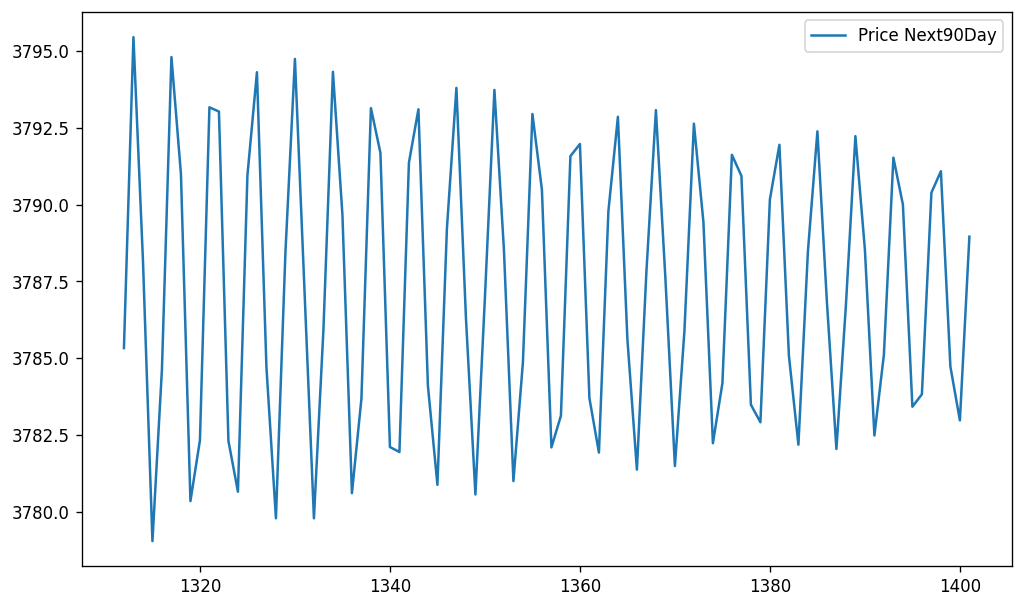

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(last_data,y_next_90_days)
plt.legend(['Price Next90Day'])
plt.show()